In [46]:
import pandas as pd
import numpy as np
from functools import reduce
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [8]:
HINDUNILVR=pd.read_csv('HINDUNILVR.BO.csv').dropna() 
PGHH = pd.read_csv('PGHH.BO.csv').dropna()
HAL= pd.read_csv('HAL.csv').dropna()
COCHINSHIP = pd.read_csv('COCHINSHIP.NS.csv').dropna()
SOLARINDS = pd.read_csv('SOLARINDS.NS.csv').dropna()
ZENTEC = pd.read_csv('ZENTEC.NS.csv').dropna()

# stock_3 = pd.read_csv('')

In [9]:
stocks = [HINDUNILVR,PGHH,HAL,COCHINSHIP,SOLARINDS,ZENTEC]

In [3]:
HINDUNILVR['Date'] = pd.to_datetime(HINDUNILVR['Date'])
PGHH['Date'] = pd.to_datetime(PGHH['Date'])
HAL['Date'] = pd.to_datetime(HAL['Date'])
COCHINSHIP['Date'] = pd.to_datetime(COCHINSHIP['Date'])
SOLARINDS['Date'] = pd.to_datetime(SOLARINDS['Date'])
ZENTEC['Date'] = pd.to_datetime(ZENTEC['Date'])

In [10]:
common_dates = reduce(lambda left, right: pd.merge(left, right, on='Date'), [stock[['Date']] for stock in stocks])


In [11]:
stocks_common = [stock[stock['Date'].isin(common_dates['Date'])].reset_index(drop=True) for stock in stocks]

In [13]:
stocks_common[1]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-08-07,15400.049805,15666.250000,15400.049805,15506.049805,15267.430664,69.0
1,2023-08-08,15619.400391,15750.000000,15582.799805,15658.599609,15417.632813,153.0
2,2023-08-09,15679.849609,15720.700195,15470.000000,15484.549805,15246.261719,120.0
3,2023-08-10,15484.000000,15637.750000,15484.000000,15607.000000,15366.827148,28.0
4,2023-08-11,15507.049805,15580.000000,15237.599609,15286.900391,15051.653320,75.0
...,...,...,...,...,...,...,...
230,2024-07-31,17038.150391,17075.099609,16853.050781,16905.650391,16905.650391,6044.0
231,2024-08-01,16855.800781,16974.050781,16467.000000,16778.400391,16778.400391,862.0
232,2024-08-02,17076.949219,17337.449219,16700.000000,17200.849609,17200.849609,293.0
233,2024-08-05,17199.949219,17199.949219,16424.000000,16686.199219,16686.199219,562.0


In [14]:
corr_data = pd.DataFrame()

In [15]:
corr_data['HINDUNILVR'] = stocks_common[0]['Open'].values
corr_data['PGHH'] = stocks_common[1]['Open'].values
corr_data['HAL'] = stocks_common[2]['Open'].values
corr_data['COCHINSHIP'] = stocks_common[3]['Open'].values
corr_data['SOLARINDS'] = stocks_common[4]['Open'].values
corr_data['ZENTEC'] = stocks_common[5]['Open'].values

In [16]:
corr_data.corr()

,HINDUNILVR,PGHH,HAL,COCHINSHIP,SOLARINDS,ZENTEC
HINDUNILVR,1.000000,0.425552,-0.251206,0.149375,-0.101327,0.163599
PGHH,0.425552,1.000000,0.076093,-0.160817,-0.185459,-0.208633
HAL,-0.251206,0.076093,1.000000,-0.638361,-0.629278,-0.520629
COCHINSHIP,0.149375,-0.160817,-0.638361,1.000000,0.914582,0.902243
SOLARINDS,-0.101327,-0.185459,-0.629278,0.914582,1.000000,0.822717
ZENTEC,0.163599,-0.208633,-0.520629,0.902243,0.822717,1.000000


- solarwind and coachinship is very correlated so we can chhose these for pair trading 

In [22]:
res_data = corr_data['SOLARINDS'] - corr_data['COCHINSHIP']

- we need to minimize the variance of spread 
- spread is given by $ price_{cochinship} - \beta *price_{solarwind} $
- we will use the optimizer libaray for this pupose

In [25]:
def spread_variance(beta, P1, P2):
    spread = P1 - beta * P2
    return np.var(spread)

# Step 3: Minimize the variance of the spread
result = minimize(spread_variance, x0=1, args=(corr_data['COCHINSHIP'], corr_data['SOLARINDS']), method='BFGS')

# Optimal beta
beta_optimal = result.x[0]

print("Optimal Hedge Ratio (Beta):", beta_optimal)

Optimal Hedge Ratio (Beta): 0.3003793401536033


In [26]:
spread = corr_data['COCHINSHIP'] - beta_optimal *  corr_data['SOLARINDS']

- estimating the parameter of the mu, theta and sigma, we will calculate the log liklihood of the data given OU process

In [29]:
def OU_log_likelihood(params, spread):
    mu, theta, sigma = params
    dt = 1  # Assuming the data is daily
    S_diff = np.diff(spread)
    S_shifted = spread[:-1]
    likelihood = -np.sum(np.log(sigma * np.sqrt(2 * np.pi * dt)) +
                         ((S_diff - theta * (mu - S_shifted) * dt)**2) / (2 * sigma**2 * dt))
    return -likelihood

In [30]:
params_initial = [np.mean(spread), 0.5, np.std(spread)]
result = minimize(OU_log_likelihood, params_initial, args=(spread,), method='L-BFGS-B')
mu_ou, theta_ou, sigma_ou = result.x

C:\Users\E080965\AppData\Local\Temp\ipykernel_10700\883733649.py:6: RuntimeWarning: invalid value encountered in log
  likelihood = -np.sum(np.log(sigma * np.sqrt(2 * np.pi * dt)) +


In [33]:
print(f"Estimated OU parameters: mu={mu_ou}, theta={theta_ou}, sigma={sigma_ou}")

Estimated OU parameters: mu=-1148.3496484422458, theta=-0.6771845007682855, sigma=-4.937730001689374


In [86]:
k = 1.5
upper_bound = mu_ou + k * sigma_ou
lower_bound = mu_ou - k * sigma_ou

In [87]:
upper_bound

-1155.7562434447798

In [88]:
lower_bound

-1140.9430534397118

In [89]:
spread.min()

-1900.315179076396

In [90]:
spread.max()

-586.9257035105893

In [111]:
positions = []
for S in spread:
    if S > upper_bound:
        positions.append(-1)  # Short spread ==> 
    elif S < lower_bound:
        positions.append(1)   # Long spread
    else:
        positions.append(0)   # Hold

In [113]:
# Convert positions to a numpy array
positions = np.array(positions)

In [114]:
# Step 5: Backtest the Strategy
# Calculate the daily returns
P1_returns = np.diff(corr_data['COCHINSHIP']) / corr_data['COCHINSHIP'][:-1]
P2_returns = np.diff(corr_data['SOLARINDS']) / corr_data['SOLARINDS'][:-1]
spread_returns = P1_returns - beta_optimal * P2_returns


In [115]:
strategy_returns = positions[:-1] * spread_returns

In [117]:
cumulative_returns = np.cumsum(strategy_returns)

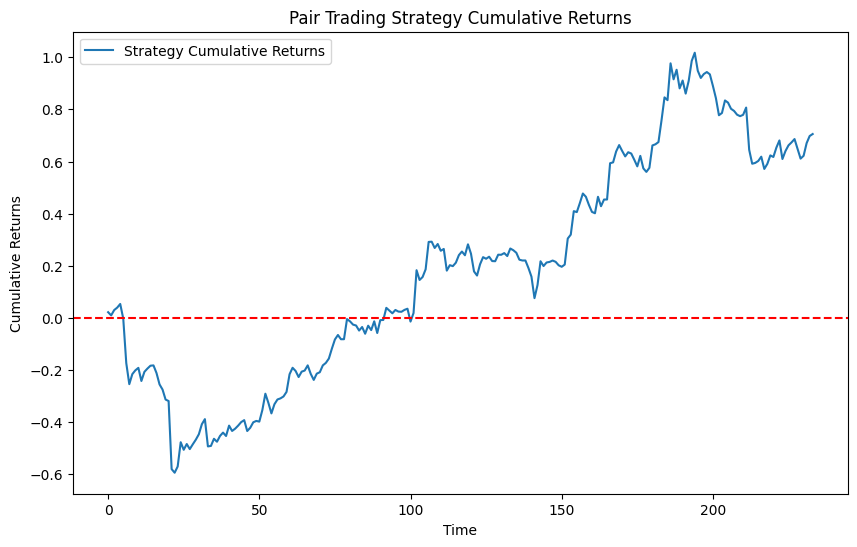

In [119]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label="Strategy Cumulative Returns")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Pair Trading Strategy Cumulative Returns")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()

In [120]:
sharpe_ratio = np.mean(strategy_returns) / np.std(strategy_returns) * np.sqrt(252)  # Annualized Sharpe Ratio
max_drawdown = np.min(cumulative_returns - np.maximum.accumulate(cumulative_returns))

print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {max_drawdown}")

Sharpe Ratio: 1.072310125549421
Max Drawdown: -0.6474032031754333
